In [56]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from lime.lime_tabular import LimeTabularExplainer
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, Flatten
import tensorflow as tf
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
import seaborn as sns
from sklearn.inspection import permutation_importance
import lime

# **ANN Model**

In [4]:
def build_ann_model(input_dim):
    model = Sequential()
    model.add(Dense(128, input_dim=input_dim, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
    return model

In [5]:
def train_ann(df):
    train_x, test_x, train_y, test_y = data_split(df)
    train_x_scaled, test_x_scaled = data_scaling(train_x, test_x)
    model = build_ann_model(train_x_scaled.shape[1])
    history = model.fit(train_x_scaled, train_y, epochs=50, batch_size=32,
                        validation_data=(test_x_scaled, test_y), verbose=1)
    test_loss, test_acc = model.evaluate(test_x_scaled, test_y)
    print(f"\nTest Accuracy: {test_acc:.4f}")

    return model, history

In [6]:
ann_model, ann_history = train_ann(df)

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.5058 - loss: 0.9094 - val_accuracy: 0.7857 - val_loss: 0.5974
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7343 - loss: 0.5717 - val_accuracy: 0.8117 - val_loss: 0.5517
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7352 - loss: 0.5531 - val_accuracy: 0.7857 - val_loss: 0.5361
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7412 - loss: 0.5160 - val_accuracy: 0.7922 - val_loss: 0.5226
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7300 - loss: 0.5725 - val_accuracy: 0.7792 - val_loss: 0.5168
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7272 - loss: 0.5186 - val_accuracy: 0.7857 - val_loss: 0.4955
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7352 - loss: 0.5097 - val_accuracy: 0.7792 - val_loss: 0.4926
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7818 - loss: 0.4734 - val_accuracy: 0.7987 - val_los

# **XAI for ANN Model**

ExactExplainer explainer: 155it [00:15,  6.86it/s]


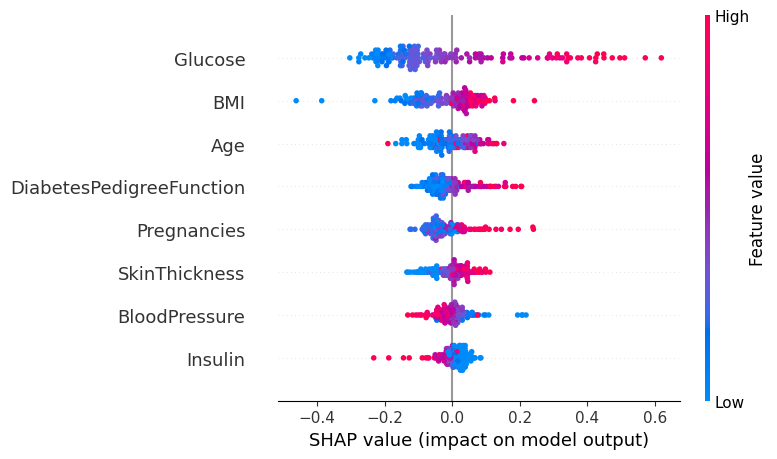

In [7]:
train_x, test_x, train_y, test_y = data_split(df)
train_x_scaled, test_x_scaled = data_scaling(train_x, test_x)
explainer_ann = shap.Explainer(ann_model, train_x_scaled)
shap_values_ann = explainer_ann(test_x_scaled)
shap.summary_plot(shap_values_ann, test_x_scaled, feature_names=train_x.columns)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


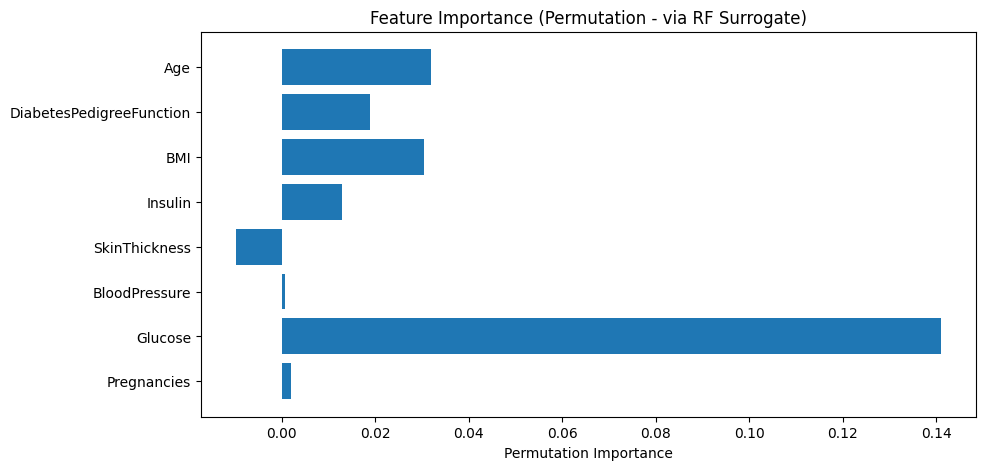

In [9]:
test_preds = ann_model.predict(test_x_scaled).flatten()
rf = RandomForestClassifier()
rf.fit(train_x_scaled, train_y)

result = permutation_importance(rf, test_x_scaled, test_y, n_repeats=10, random_state=42)

plt.figure(figsize=(10, 5))
plt.barh(train_x.columns, result.importances_mean)
plt.xlabel("Permutation Importance")
plt.title("Feature Importance (Permutation - via RF Surrogate)")
plt.show()

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


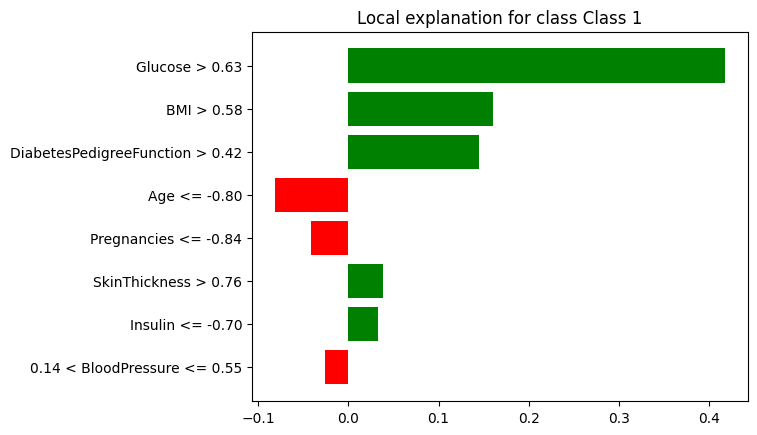

In [12]:
explainer = LimeTabularExplainer(train_x_scaled,
                                 feature_names=train_x.columns.tolist(),
                                 class_names=['Class 0', 'Class 1'],
                                 mode='classification')

def predict_proba_fn(x):
    probs = ann_model.predict(x)
    return np.hstack((1 - probs, probs))

i = 0
exp = explainer.explain_instance(
    test_x_scaled[i],
    predict_proba_fn,
    num_features=10
)

exp.as_pyplot_figure()
plt.show()

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


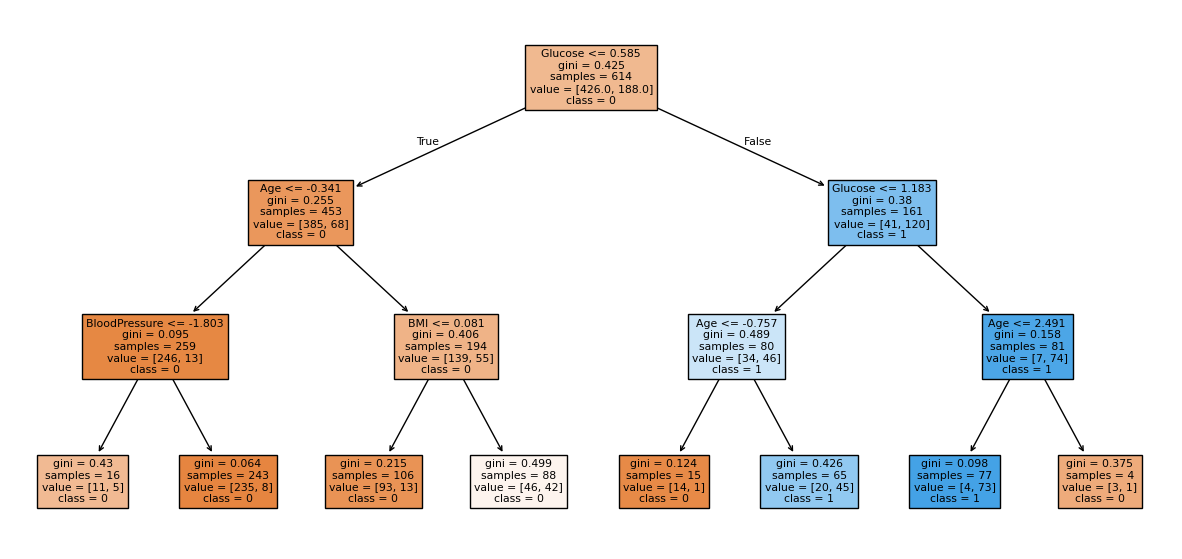

In [29]:
y_surrogate = (ann_model.predict(train_x_scaled) > 0.5).astype(int)

tree_model = DecisionTreeClassifier(max_depth=3)
tree_model.fit(train_x_scaled, y_surrogate)

plt.figure(figsize=(15, 7))
tree.plot_tree(tree_model, feature_names=train_x.columns, class_names=["0", "1"], filled=True)
plt.show()

# **Conv-LSTM Model**

In [36]:
def reshape_for_convlstm(X, time_steps=1):
    n_samples, n_features = X.shape
    side = int(np.ceil(np.sqrt(n_features)))
    padded = np.zeros((n_samples, side * side))
    padded[:, :n_features] = X
    reshaped = padded.reshape((n_samples, time_steps, side, side, 1))
    return reshaped

In [37]:
def build_convlstm_model(input_shape):
    model = Sequential()
    model.add(ConvLSTM2D(filters=32, kernel_size=(3,3), activation='relu',
                         input_shape=input_shape, return_sequences=False))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [38]:
def train_convlstm(df):
    train_x, test_x, train_y, test_y = data_split(df)
    train_x_scaled, test_x_scaled = data_scaling(train_x, test_x)
    train_x_reshaped = reshape_for_convlstm(train_x_scaled)
    test_x_reshaped = reshape_for_convlstm(test_x_scaled)
    model = build_convlstm_model(train_x_reshaped.shape[1:])
    history = model.fit(train_x_reshaped, train_y, epochs=20, batch_size=32,
                        validation_data=(test_x_reshaped, test_y), verbose=1)
    test_loss, test_acc = model.evaluate(test_x_reshaped, test_y)
    print(f"\nTest Accuracy: {test_acc:.4f}")

    return model

In [39]:
model = train_convlstm(df)

Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.6797 - loss: 0.6021 - val_accuracy: 0.7857 - val_loss: 0.6615
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7113 - loss: 0.5351 - val_accuracy: 0.7662 - val_loss: 0.6412
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7741 - loss: 0.4795 - val_accuracy: 0.7662 - val_loss: 0.6266
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7822 - loss: 0.4506 - val_accuracy: 0.7857 - val_loss: 0.6187
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7794 - loss: 0.4821 - val_accuracy: 0.7792 - val_loss: 0.6142
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7699 - loss: 0.4876 - val_accuracy: 0.7857 - val_loss: 0.6112
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7828 - loss: 0.4865 - val_accuracy: 0.7922 - val_loss: 0.6090
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8095 - loss: 0.4490 - val_accuracy: 0.7857 - val_lo

# **XAI for Conv-LSTM Model**

In [40]:
train_x, test_x, train_y, test_y = data_split(df)
train_x_scaled, test_x_scaled = data_scaling(train_x, test_x)

train_x_reshaped = reshape_for_convlstm(train_x_scaled)
test_x_reshaped = reshape_for_convlstm(test_x_scaled)

In [41]:
def plot_saliency_map(model, input_sample, class_index=0):
    input_tensor = tf.convert_to_tensor(input_sample[None, ...])
    with tf.GradientTape() as tape:
        tape.watch(input_tensor)
        preds = model(input_tensor, training=False)
        output = preds[:, class_index] if preds.shape[1] > 1 else preds
    grads = tape.gradient(output, input_tensor)[0]
    saliency = tf.reduce_max(tf.abs(grads), axis=-1).numpy()
    saliency_avg = np.mean(saliency, axis=0)

    plt.imshow(saliency_avg, cmap='hot')
    plt.title("Saliency Map (Averaged Over Time)")
    plt.colorbar()
    plt.show()

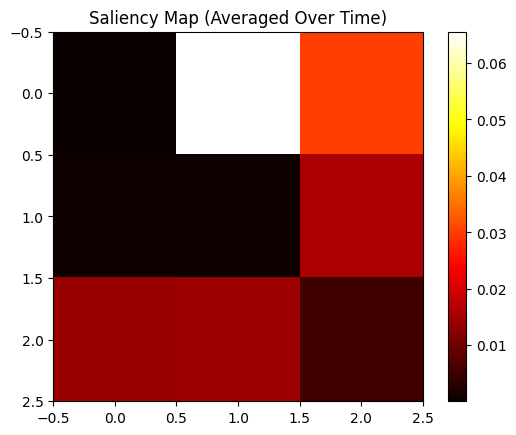

In [42]:
sample = test_x_reshaped[0]
plot_saliency_map(model, sample)

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


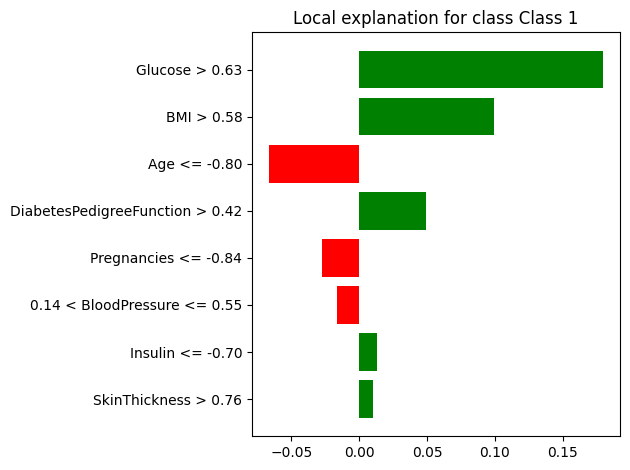

In [43]:
train_x, test_x, train_y, test_y = data_split(df)
train_x_scaled, test_x_scaled = data_scaling(train_x, test_x)

explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=train_x_scaled,
    feature_names=train_x.columns.tolist(),
    class_names=["Class 0", "Class 1"],
    mode='classification'
)

def predict_for_lime(instance):
    reshaped = reshape_for_convlstm(instance)
    return np.hstack([
        1 - model.predict(reshaped),
        model.predict(reshaped)
    ])

i = 0
instance = test_x_scaled[i].reshape(1, -1)
exp = explainer.explain_instance(instance[0], predict_for_lime, num_features=10)

exp.as_pyplot_figure()
plt.tight_layout()
plt.show()

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


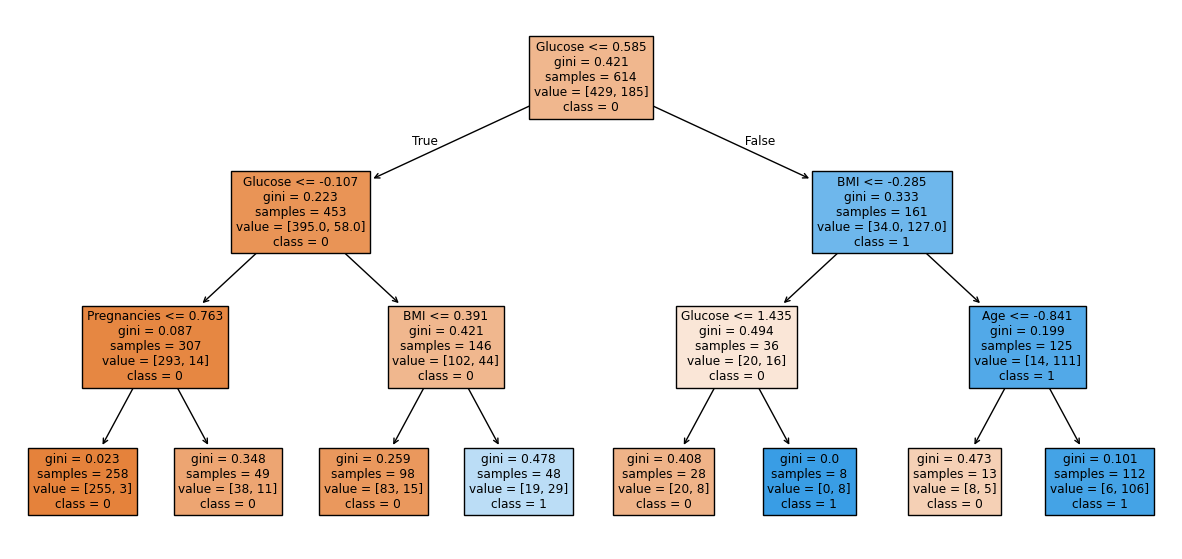

In [53]:
y_surrogate = (model.predict(train_x_reshaped).flatten() > 0.5).astype(int)

tree_model = DecisionTreeClassifier(max_depth=3)
tree_model.fit(train_x_scaled, y_surrogate)

plt.figure(figsize=(15, 7))
tree.plot_tree(tree_model, feature_names=train_x.columns, class_names=["0", "1"], filled=True)
plt.show()

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


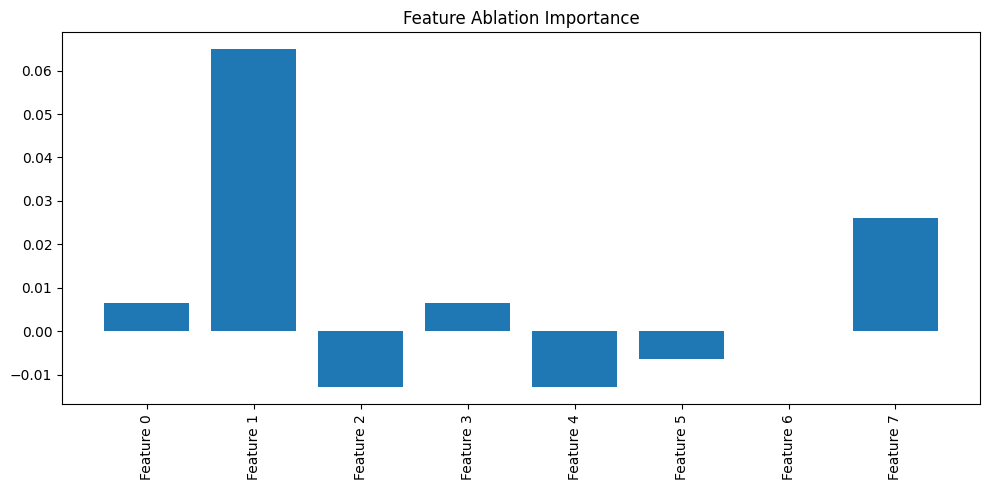

In [55]:
base_preds = (model.predict(test_x_reshaped).flatten() > 0.5).astype(int)
base_acc = accuracy_score(test_y, base_preds)

importances = []

for i in range(test_x_scaled.shape[1]):
    X_temp = test_x_scaled.copy()
    X_temp[:, i] = 0

    X_temp_reshaped = reshape_for_convlstm(X_temp)
    preds = (model.predict(X_temp_reshaped).flatten() > 0.5).astype(int)

    acc = accuracy_score(test_y, preds)
    importances.append(base_acc - acc)

plt.figure(figsize=(10, 5))
plt.bar(range(len(importances)), importances)
plt.xticks(range(len(importances)), [f'Feature {i}' for i in range(test_x_scaled.shape[1])], rotation=90)
plt.title("Feature Ablation Importance")
plt.tight_layout()
plt.show()

# **Medium KNN Model**

In [30]:
def medium_knn(df):
    train_x, test_x, train_y, test_y = data_split(df)

    train_x_scaled, test_x_scaled = data_scaling(train_x, test_x)

    k = 5
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(train_x_scaled, train_y)

    test_y_pred = knn.predict(test_x_scaled)

    print(f" Medium KNN model (k = {k})")
    print("Training Accuracy: {:.4f}".format(knn.score(train_x_scaled, train_y)))
    print("Test Accuracy: {:.4f}".format(knn.score(test_x_scaled, test_y)))

    tn, fp, fn, tp = confusion_matrix(test_y, test_y_pred).ravel()
    print("\n Classification Report:\n", classification_report(test_y, test_y_pred))
    print("Testing: Sensitivity (Recall):", tp / (tp + fn), "Specificity:", tn / (tn + fp))

In [31]:
medium_knn(df)

 Medium KNN model (k = 5)
Training Accuracy: 0.8111
Test Accuracy: 0.7987

 Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.87      0.86       107
           1       0.68      0.64      0.66        47

    accuracy                           0.80       154
   macro avg       0.76      0.75      0.76       154
weighted avg       0.80      0.80      0.80       154

Testing: Sensitivity (Recall): 0.6382978723404256 Specificity: 0.8691588785046729


# **XAI for Medium KNN Model**

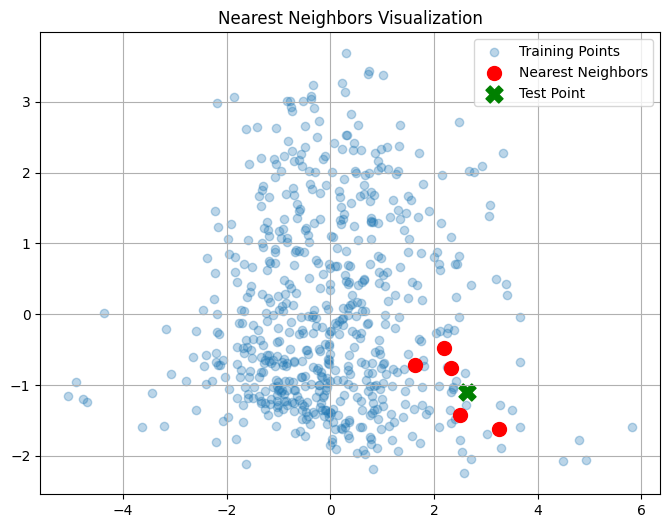

In [32]:
nbrs = NearestNeighbors(n_neighbors=5).fit(train_x_scaled)
point = test_x_scaled[0].reshape(1, -1)
distances, indices = nbrs.kneighbors(point)

pca = PCA(n_components=2)
train_2d = pca.fit_transform(train_x_scaled)
point_2d = pca.transform(point)
neighbors_2d = train_2d[indices[0]]

plt.figure(figsize=(8,6))
plt.scatter(train_2d[:,0], train_2d[:,1], alpha=0.3, label='Training Points')
plt.scatter(neighbors_2d[:,0], neighbors_2d[:,1], color='red', label='Nearest Neighbors', s=100)
plt.scatter(point_2d[:,0], point_2d[:,1], color='green', label='Test Point', s=150, marker='X')
plt.title("Nearest Neighbors Visualization")
plt.legend()
plt.grid(True)
plt.show()

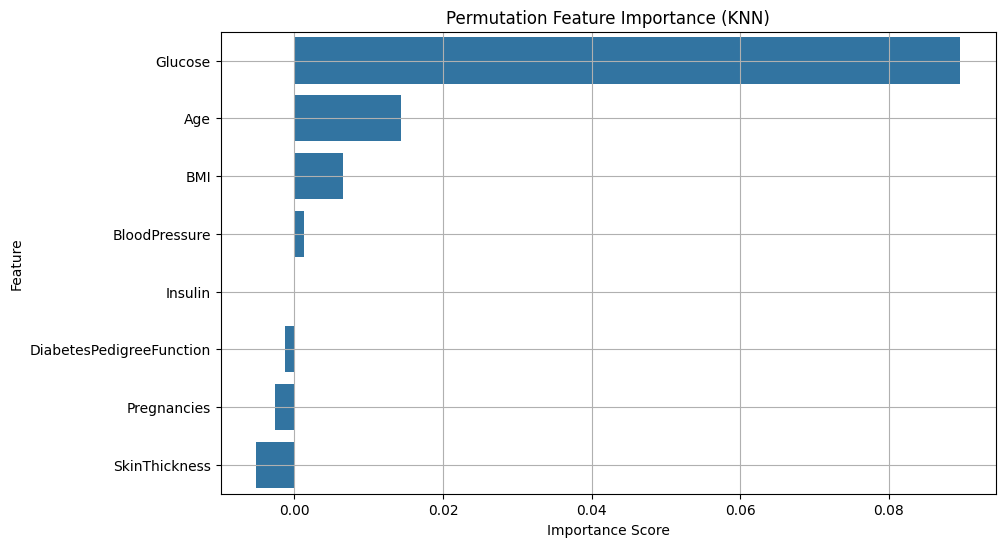

In [33]:
knn = KNeighborsClassifier(n_neighbors=7).fit(train_x_scaled, train_y)
result = permutation_importance(knn, test_x_scaled, test_y, scoring='accuracy')

feature_names = df.columns[:-1]
importances = result.importances_mean
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
sns.barplot(x=importances[indices], y=feature_names[indices])
plt.title("Permutation Feature Importance (KNN)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.grid(True)
plt.show()

Intercept 0.2699520795439506
Prediction_local [0.66613653]
Right: 1.0


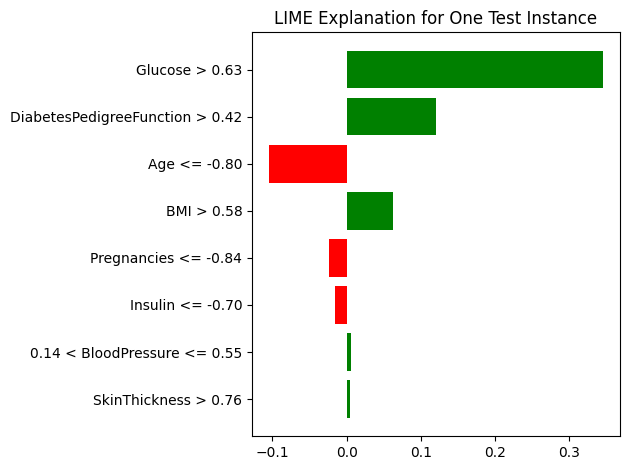

In [34]:
explainer = lime.lime_tabular.LimeTabularExplainer(
    train_x_scaled,
    feature_names=df.columns[:-1],
    class_names=['Class 0', 'Class 1'],
    verbose=True,
    mode='classification'
)

exp = explainer.explain_instance(test_x_scaled[0], knn.predict_proba)
exp.as_pyplot_figure()
plt.title("LIME Explanation for One Test Instance")
plt.tight_layout()
plt.show()

ExactExplainer explainer: 155it [05:06,  2.06s/it]


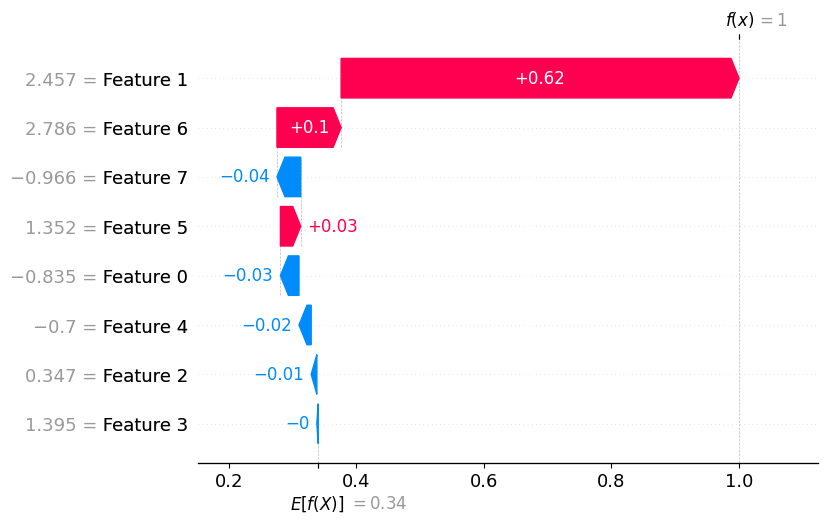

In [35]:
explainer = shap.Explainer(knn.predict, train_x_scaled)
shap_values = explainer(test_x_scaled)

shap.plots.waterfall(shap_values[0], max_display=10)